## k-means 

k-means 聚类应该是最简单的无监督学习算法了。 k-means 涉及的知识点有：
1. 算法衡量 (SSE, Sum of squared error)。
2. 合并策略
    a. 合并两个最近的质心
    b. 合并两个使得 SSE 增幅最小的质心。
3. 距离计算公式。
4. 随机选择策略。
5. 为了克服 k-means 算法限入局部最小值问题，可以通过二分 k-means 算法(bisecting K-means)来进行划分。


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def loadData(file):
    return pd.read_csv(file, delimiter='\t', header=None)

In [49]:
def plotKmeans(X, clusterErrors, centroids):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    k = len(centroids)
    for i in range(k):
        idx = np.nonzero(clusterErrors[:, 0] == i)[0]
        ax.scatter(X[:, 0][idx], X[:, 1][idx])
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=60, c='k')
    return
    

In [60]:
def calcEclud(xi, xj):
    '''
        计算欧式距离
    '''
    return np.sqrt(np.sum((xi - xj) ** 2))

def selectKCentroids(X, k):
    '''
        选择 k 个质心。可以随机选择 k 个样本作为质心。也可以计算特征的 min, max 来随机生成。
    '''
    m = X.shape[0]
    idx = np.random.permutation(m)[0:k]
    return X[idx].copy()

def kmeans(X, k, calcDist = calcEclud, selectCentroids = selectKCentroids, plot = False):
    m,n = X.shape
    centroids = selectCentroids(X, k)
    changed = True
    clusterErrors = np.zeros((m, 2))
    sse = []
    
    if plot : plotKmeans(X, clusterErrors, centroids)
    
    while(changed):
        changed = False
        for i in range(m):
            minDist, cluster = np.inf, -1
            for j in range(k):
                dist = calcDist(X[i], centroids[j])
                if dist <= minDist :
                    minDist, cluster = dist, j
            if cluster != clusterErrors[i, 0]:
                changed = True
                
            clusterErrors[i] = cluster, minDist **2 # 方便我们统计 SSE
            
        for j in range(k):
            idx = np.nonzero(clusterErrors[:, 0] == j)[0]
            centroids[j] = np.mean(X[idx], axis = 0)
        if plot : plotKmeans(X, clusterErrors, centroids)
        sse.append(sum(clusterErrors[:, 1]))
    
    return centroids, clusterErrors, sse

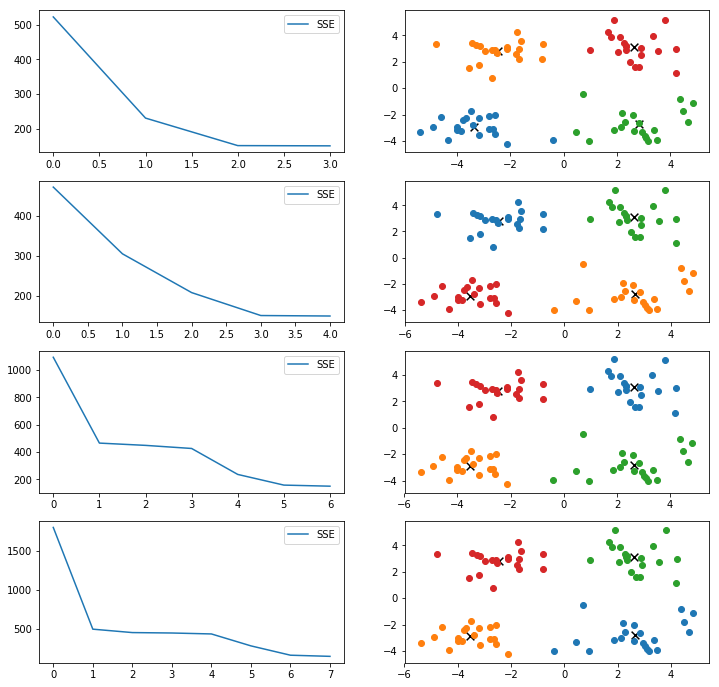

In [85]:
data = loadData('testSet.txt')
X = data.values

# 执行 4 看下最终的 SSE 有合不同
times = 4
results = []
for i in range(times):
    centroids, clusterErrors, sse = kmeans(X, 4)
    results.append((centroids, clusterErrors, sse))

fig, ax = plt.subplots(nrows=times, ncols=2, sharex=False, sharey=False, figsize=(12, 3 * times))

for i in range(times):
    cents, errors, sse = results[i]
    ax[i, 0].plot(range(len(sse)), sse, label='SSE')
    ax[i, 0].legend()
    
    ax[i, 1].scatter(cents[:, 0], cents[:, 1], marker='x', s=60, c='k')
    k = len(cents)
    for j in range(k):
        idx = np.nonzero(errors[:, 0] == j)[0]
        ax[i, 1].scatter(X[:, 0][idx], X[:, 1][idx])


### 二分 k-means 算法
上面的二分法对初始随机选择的质心很敏感，很容易陷入局部最小化中。影响划分效果和迭代次。

我们可以根据二分 k-means 算法来进行优化。每次找一个最能降低 SSE 的簇进行二分，即有最小的 SSE, 直到簇的个数等于 K.

In [98]:
def biKmeans(X, k, calcDist = calcEclud):
    m, n = X.shape
    clusterErrors = np.zeros((m, 2))
    
    # 首先初始化一个簇，可以将均值作为初始质心，并且初始化 SSE。
    centroid0 = np.mean(X, axis = 0)
    centList = [centroid0]
    for i in range(m):
        clusterErrors[i] = 0, calcDist(centroid0, X[i])
    
    while (len(centList) < k):
        minSSE = np.inf
        nums = len(centList)
        for i in range(nums):
            iIdx = np.nonzero(clusterErrors[:, 0] == i)[0]
            iNotIdx = np.nonzero(clusterErrors[:, 0] != i)[0]
            
            iNotSSE = np.sum(clusterErrors[:, 1][iNotIdx])
            iData = X[iIdx]
            biCentroids, biErros, biSSEs = kmeans(iData, 2)
            iSSE = biSSEs[-1]
            
            if (iSSE + iNotSSE) < minSSE:
                splitI = i
                splitCentroids = biCentroids
                splitErrors = biErros
                minSSE = iSSE + iNotSSE
            
        posIdx = np.nonzero(splitErrors[:, 0] == 0)[0]
        negIdx = np.nonzero(splitErrors[:, 0] == 1)[0]
        splitErrors[:, 0][posIdx] = splitI
        splitErrors[:, 0][negIdx] = nums
        
        print('The best split cluster is :', splitI)
        centList[splitI] = biCentroids[0]
        centList.append(biCentroids[1])
        splitIdx = np.nonzero(clusterErrors[:, 0] == splitI)[0]
        clusterErrors[splitIdx] = splitErrors
    return np.mat(centList), clusterErrors

The best split cluster is : 0
The best split cluster is : 1
The best split cluster is : 2


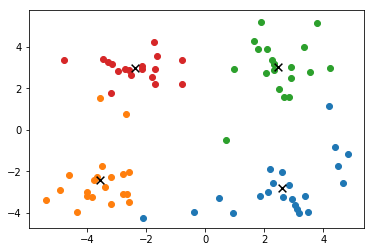

In [118]:
centroids, clusterErrors = biKmeans(X, 4)
plotKmeans(X, clusterErrors, np.asarray(centroids))